In [1]:
import sanitizer as sn
import data_reader as dr

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
import pprint

pp = pprint.PrettyPrinter()

In [4]:
# mongodb connection details
mongodb_URI = "mongodb://localhost:27017"
dbs = ['riskMetrics12720210940', 'riskMetrics12720211049', 'riskMetrics12720210728', 'riskMetrics12720210714']

In [5]:
mongo_dbs = [dr.read_data(mongodb_URI, db) for db in dbs]
mongo_data = []

for d in mongo_dbs:
    mongo_data.append([sn.sanitize(a) for a in d])

measurements = [item for sublist in mongo_data for item in sublist]

In [6]:
# Initializing the dataframe
data = pd.DataFrame(measurements)

In [7]:
# del data['configuration']
del data['mvpNode']
del data['classification']

In [8]:
# Check the shape of dataframe
data.shape

(1961, 13)

In [9]:
data.head()

,configuration,drugAmount,heartRate,lockoutInterval,riskValue,spo2,takingOtherMedications,o2Supplement,apnea,riskAge,weight,etCO2,respirationRate
0,1,1,60,2,29.0676,98,1,0,0,0,2,NaN,NaN
1,1,1,60,2,29.0209,98,1,0,0,0,2,NaN,NaN
2,1,1,60,2,28.8772,98,1,0,0,0,2,NaN,NaN
3,1,1,60,2,28.7705,98,1,0,0,0,2,NaN,NaN
4,1,1,60,2,28.8802,98,1,0,0,0,2,NaN,NaN


In [10]:
# Viewing the data statistics
data.describe()

,configuration,drugAmount,heartRate,lockoutInterval,riskValue,spo2,takingOtherMedications,o2Supplement,apnea,riskAge,weight,etCO2,respirationRate
count,1961.000000,1961.000000,1961.000000,1961.000000,1961.00000,1961.000000,1961.0,1961.000000,1961.000000,1961.000000,1961.000000,517.000000,517.000000
mean,1.527282,1.500765,49.714431,1.767466,52.10994,88.170321,1.0,1.001530,0.506884,0.739419,2.739419,30.121857,14.653772
std,0.881439,0.500127,6.374378,0.422556,12.39918,6.230239,0.0,1.000254,0.500080,0.439064,0.439064,1.774782,0.881578
min,1.000000,1.000000,44.000000,1.000000,17.28000,82.000000,1.0,0.000000,0.000000,0.000000,2.000000,28.000000,11.000000
25%,1.000000,1.000000,44.000000,2.000000,47.90240,82.000000,1.0,0.000000,0.000000,0.000000,2.000000,30.000000,15.000000
50%,1.000000,2.000000,47.000000,2.000000,51.74150,86.000000,1.0,2.000000,1.000000,1.000000,3.000000,30.000000,15.000000
75%,3.000000,2.000000,55.000000,2.000000,58.95790,94.000000,1.0,2.000000,1.000000,1.000000,3.000000,30.000000,15.000000
max,3.000000,2.000000,70.000000,2.000000,73.53610,98.000000,1.0,2.000000,1.000000,1.000000,3.000000,44.000000,15.000000


In [11]:
# Finding out the correlation between the features
corr = data.corr()
corr.shape

(13, 13)

<AxesSubplot:>

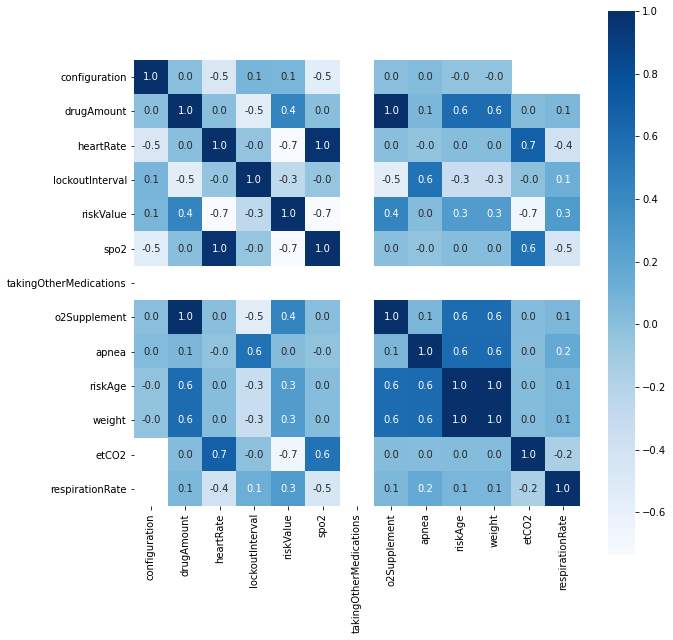

In [12]:
# Plotting the heatmap of correlation between features
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    cbar=True,
    square=True,
    fmt=".1f",
    annot=True,
    annot_kws={"size": 10},
    cmap="Blues",
)

### Predict Missing Values

In [13]:
# Convert to a pandas dataframe like in your example
icols = ['configuration', 'drugAmount', 'lockoutInterval', 
         'riskValue', 'takingOtherMedications', 'o2Supplement', 
         'apnea', 'riskAge', 'weight']

# config 1 - 3
icols.extend(['heartRate', 'spo2'])
jcols = ['etCO2', 'respirationRate']

# config 2 - 3
# icols.extend(['etCO2', 'respirationRate'])
# jcols = ['heartRate', 'spo2']

In [14]:
notnans = data[jcols].notnull().all(axis=1)
df_notnans = data[notnans]

# Split into 75% train and 25% test
X_train, X_test, y_train, y_test = train_test_split(df_notnans[icols], df_notnans[jcols],
                                                    train_size=0.75,
                                                    random_state=4)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

regr_multirf = MultiOutputRegressor(RandomForestRegressor(max_depth=30,
                                                          random_state=0))

# Fit on the train data
regr_multirf.fit(X_train, y_train)

# Check the prediction score
score = regr_multirf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

The prediction score on the test data is 83.26%


In [16]:
df_nans = data.loc[~notnans].copy()
df_nans[jcols] = regr_multirf.predict(df_nans[icols])

In [17]:
df_nans

,configuration,drugAmount,heartRate,lockoutInterval,riskValue,spo2,takingOtherMedications,o2Supplement,apnea,riskAge,weight,etCO2,respirationRate
0,1,1,60,2,29.0676,98,1,0,0,0,2,43.4,12.68
1,1,1,60,2,29.0209,98,1,0,0,0,2,43.4,12.68
2,1,1,60,2,28.8772,98,1,0,0,0,2,43.4,12.68
3,1,1,60,2,28.7705,98,1,0,0,0,2,43.4,12.68
4,1,1,60,2,28.8802,98,1,0,0,0,2,43.4,12.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,1,2,44,2,72.9594,82,1,2,1,1,3,29.0,13.31
1790,1,2,44,2,72.9767,82,1,2,1,1,3,29.0,13.31
1791,1,2,44,2,72.7671,82,1,2,1,1,3,29.0,13.31
1792,1,2,44,2,72.9346,82,1,2,1,1,3,29.0,13.31


In [18]:
data = df_nans

In [19]:
print(data.shape)
data = data.dropna()
print(data.shape)

(1444, 13)
(1444, 13)


## Spliting data

In [20]:
# Spliting target variable and independent variables
X = data.drop(["riskValue"], axis=1)
y = data["riskValue"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=4)

# Linear regression

#### Training the model

In [21]:
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

LinearRegression()

In [22]:
# Value of y intercept
lm.intercept_

353.3917255149132

In [23]:
# Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns, lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: "Attribute", 1: "Coefficients"})
coeffcients

,Attribute,Coefficients
0,configuration,0
1,drugAmount,1.98397
2,heartRate,3.89576
3,lockoutInterval,-0.379371
4,spo2,-5.80235
5,takingOtherMedications,4.44089e-16
6,o2Supplement,3.96795
7,apnea,-0.0438951
8,riskAge,0.335476
9,weight,0.335476


In [24]:
# Model prediction on train data
y_pred = lm.predict(X_train)

In [25]:
# Model Evaluation
print("R^2:", metrics.r2_score(y_train, y_pred))
print(
    "Adjusted R^2:",
    1
    - (1 - metrics.r2_score(y_train, y_pred))
    * (len(y_train) - 1)
    / (len(y_train) - X_train.shape[1] - 1),
)
print("MAE:", metrics.mean_absolute_error(y_train, y_pred))
print("MSE:", metrics.mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9414723181936758
Adjusted R^2: 0.9394541222693198
MAE: 2.845550864094082
MSE: 11.604308277526748
RMSE: 3.4065096913889366


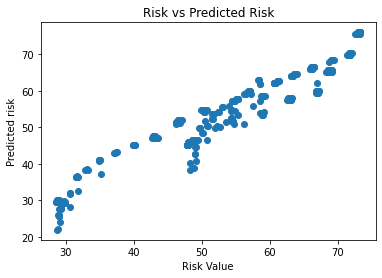

In [26]:
plt.scatter(y_train, y_pred)
plt.xlabel("Risk Value")
plt.ylabel("Predicted risk")
plt.title("Risk vs Predicted Risk")
plt.show()

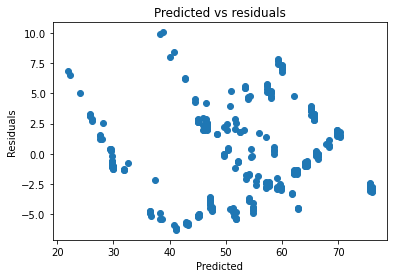

In [27]:
# Checking residuals
plt.scatter(y_pred, y_train - y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [28]:
# Predicting Test data with the model
y_test_pred = lm.predict(X_test)
acc_lr = metrics.r2_score(y_test, y_test_pred)

print("R^2:", acc_lr)
print(
    "Adjusted R^2:",
    1
    - (1 - metrics.r2_score(y_test, y_test_pred))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1),
)
print("MAE:", metrics.mean_absolute_error(y_test, y_test_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.9412091849748202
Adjusted R^2: 0.9405498487315471
MAE: 2.804061316710658
MSE: 11.57778599165503
RMSE: 3.402614581708459


In [29]:
y_list = y_test.to_list()

print('Prediction \tValue')
for i in range(20):
    print("{:.3f}".format(y_test_pred[i]), "{:15.3f}".format(y_list[i]))

Prediction 	Value
65.741          69.061
29.671          29.257
68.372          69.241
42.075          48.179
54.210          50.447
54.039          58.740
41.127          34.794
76.081          73.127
46.606          48.812
54.039          59.280
57.195          54.600
38.570          32.988
75.658          73.159
30.000          29.151
46.606          48.943
42.710          48.716
46.081          48.254
48.446          50.102
60.240          64.057
76.081          73.222


# SVM Regressor


In [30]:
# Creating scaled set to be used in model to improve our results
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Train the model

In [31]:
# Import SVM Regressor
from sklearn import svm

# Create a SVM Regressor
reg = svm.SVR()

In [32]:
# Train the model using the training sets
reg.fit(X_train, y_train)

SVR()

#### Model Evaluation

In [33]:
# Model prediction on train data
y_pred = reg.predict(X_train)

In [34]:
# Model Evaluation
print("R^2:", metrics.r2_score(y_train, y_pred))
print(
    "Adjusted R^2:",
    1
    - (1 - metrics.r2_score(y_train, y_pred))
    * (len(y_train) - 1)
    / (len(y_train) - X_train.shape[1] - 1),
)
print("MAE:", metrics.mean_absolute_error(y_train, y_pred))
print("MSE:", metrics.mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9683497587003977
Adjusted R^2: 0.967258371069377
MAE: 1.5886583440884625
MSE: 6.2753067567936265
RMSE: 2.505056238249678


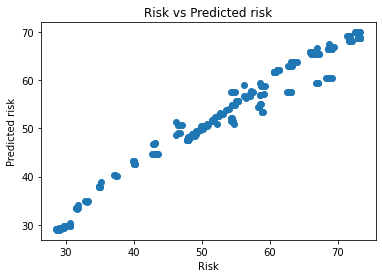

In [35]:
plt.scatter(y_train, y_pred)
plt.xlabel("Risk")
plt.ylabel("Predicted risk")
plt.title("Risk vs Predicted risk")
plt.show()

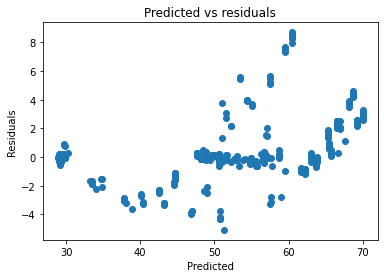

In [36]:
# Checking residuals
plt.scatter(y_pred, y_train - y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

#### For test data

In [37]:
# Predicting Test data with the model
y_test_pred = reg.predict(X_test)

In [38]:
# Model Evaluation
acc_svm = metrics.r2_score(y_test, y_test_pred)
print("R^2:", acc_svm)
print(
    "Adjusted R^2:",
    1
    - (1 - metrics.r2_score(y_test, y_test_pred))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1),
)
print("MAE:", metrics.mean_absolute_error(y_test, y_test_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.9638595267610484
Adjusted R^2: 0.9634542130424807
MAE: 1.67495727189569
MSE: 7.117211500104356
RMSE: 2.667810244396021


In [39]:
y_list = y_test.to_list()

print("Prediction \tActual\n")
for i in range(20):
    print("{:.3f}".format(y_test_pred[i]), "{:15.3f}".format(y_list[i]))

Prediction 	Actual

66.519          69.061
29.113          29.257
66.956          69.241
48.614          48.179
50.419          50.447
55.027          58.740
37.851          34.794
68.732          73.127
48.833          48.812
55.027          59.280
54.886          54.600
34.731          32.988
69.966          73.159
28.993          29.151
48.833          48.943
48.854          48.716
48.184          48.254
49.932          50.102
64.666          64.057
68.732          73.222


# Gaussian Naive Bayes

In [40]:
mongo_dbs = [dr.read_data(mongodb_URI, db) for db in dbs]
mongo_data = []

for d in mongo_dbs:
    mongo_data.append([sn.sanitize_naive_bayes(a) for a in d])

measurements = [item for sublist in mongo_data for item in sublist]
    
data = pd.DataFrame(measurements)

In [41]:
# del data['configuration']
del data['mvpNode']
# del data['classification']
del data['riskValue']

In [42]:
data.head()

,classification,configuration,drugAmount,etCO2,heartRate,lockoutInterval,respirationRate,spo2,takingOtherMedications,o2Supplement,apnea,riskAge,weight
0,Minor,cfg_1,Low,no_data,Negligible,Medium,no_data,Negligible,yes,None,no,no,Normal
1,Minor,cfg_1,Low,no_data,Negligible,Medium,no_data,Negligible,yes,None,no,no,Normal
2,Minor,cfg_1,Low,no_data,Negligible,Medium,no_data,Negligible,yes,None,no,no,Normal
3,Minor,cfg_1,Low,no_data,Negligible,Medium,no_data,Negligible,yes,None,no,no,Normal
4,Minor,cfg_1,Low,no_data,Negligible,Medium,no_data,Negligible,yes,None,no,no,Normal


In [43]:
X = data.drop(["classification"], axis=1)
y = data["classification"]

In [44]:
from sklearn.preprocessing import LabelEncoder

In [45]:
#cfg 1
X['heartRate'] = LabelEncoder().fit_transform(X['heartRate'])
X['spo2'] = LabelEncoder().fit_transform(X['spo2'])

#cfg 2
X['etCO2'] = LabelEncoder().fit_transform(X['etCO2'])
X['respirationRate'] = LabelEncoder().fit_transform(X['respirationRate'])

X['configuration'] = LabelEncoder().fit_transform(X['configuration'])
X['drugAmount'] = LabelEncoder().fit_transform(X['drugAmount'])
X['lockoutInterval'] = LabelEncoder().fit_transform(X['lockoutInterval'])
X['takingOtherMedications'] = LabelEncoder().fit_transform(X['takingOtherMedications'])
X['o2Supplement'] = LabelEncoder().fit_transform(X['o2Supplement'])
X['apnea'] = LabelEncoder().fit_transform(X['apnea'])
X['riskAge'] = LabelEncoder().fit_transform(X['riskAge'])
X['weight'] = LabelEncoder().fit_transform(X['weight'])

In [46]:
from sklearn.naive_bayes import GaussianNB

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [48]:
# Predicting Test data with the model
y_test_pred = nb.predict(X_test)

# Model Evaluation
acc_nb = metrics.accuracy_score(y_test, y_test_pred)
print("R^2:", acc_nb)

R^2: 0.4282800815771584


In [49]:
y_list = y_test.to_list()

print("Prediction \tActual\n")
for i in range(20):
    print("{:15}".format(y_test_pred[i]), "{0}".format(y_list[i]))

Prediction 	Actual

Serious         Serious
Critical        Serious
Critical        Critical
Serious         Serious
Critical        Serious
Critical        Serious
Serious         Serious
Critical        Serious
Critical        Serious
Critical        Critical
Serious         Serious
Critical        Serious
Critical        Serious
Critical        Minor
Critical        Serious
Serious         Serious
Critical        Minor
Serious         Serious
Critical        Serious
Critical        Serious
